# MMMI Oversight Script


**TODO**: Consolidate configuration parameters.

**TODO**: Consolidate population model.

**TODO**: `requirements.txt`

**TODO**: Proper scaling of subdivisions of a quarter

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

**TODO**: Consolidate initial setup to use same scripts as in interim. I.e., by having all agents 'attentive' to start.

**TODO**: Test for expected behavior with maximum attention rating (1)

**TODO**: Begin automated tests

**TODO**: Scale the 'Share' when asset levels adjust due to capital gains (currently the gains are being added to 'risk free' wealth proportional to share).

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)

import logging
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:

import hark_portfolio_agents as hpa

import util as UTIL

## Portfolio Consumption Model

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

In [3]:
risky_asset_price = 100

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [4]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [5]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Quarterly dividend rate and standard deviation.

In [6]:
dividend_ror = 0.03
dividend_std = 0.01

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [7]:
days_per_quarter = 5 # should be 60
quarters_per_simulation = 4

An attention rate: the chance on any day that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [8]:
attention_rate = 1.5 / days_per_quarter ## upping this to make more agents engaged in trade

A times we will need to combine the quarterly rates from the price process (capital gains) and the dividends.


### Data stores

For prices, rates or return, and standard deviations over time.

In [9]:
prices = [100]
ror_list = []
std_list = []

expected_ror_list = []
expected_std_list = []

buy_sell_list = []

owned_shares_list = []
total_asset_levels_list = []

### Calculating risky expectations



A number of constants used in the calculation of risky expectations.

In [10]:
import math

p1 = 0.1
delta_t1 = 30

a = - math.log(p1) / delta_t1

p2 = 0.1
delta_t2 = 60

b = math.log(p2) / delta_t2

print(a)

print(b)

0.07675283643313485
-0.038376418216567426


In [11]:
def calculate_risky_expectations():
    """
    Compute the expectations for the risky asset based on historical return rates.
    
    In this implementation there are a number of references to:
      - paramters that are out of scope
      - data structures that are out of scope
     
    These should be bundled together somehow.
    """
    # note use of data store lists for time tracking here -- not ideal
    D_t = sum([math.exp(a * (l + 1)) for l in range(len(ror_list))])
    S_t = math.exp(b * (len(prices) - 1)) # because p_0 is included in this list.
    
    w_0 = S_t
    w_t = [(1 - S_t) * math.exp(a * (t+1)) / D_t for t in range(len(ror_list))]
    
    print(f"D_t: {D_t}\nS_t / w_0  : {S_t}") # "\nror_list: {ror_list}\n w_t: {w_t}")
    
    expected_ror = w_0 * sp500_ror + sum(
        [w_ror[0] * w_ror[1]
         for w_ror
         in zip(w_t, ror_list)])
    expected_ror_list.append(expected_ror)
    
    expected_std = math.sqrt(
        w_0 * pow(sp500_std, 2) \
        +  sum([w_ror_er[0] * pow(w_ror_er[1] - expected_ror, 2)
                for w_ror_er
                in zip(w_t, ror_list)]))
    expected_std_list.append(expected_std)
    
    print(f'daily expectations: {expected_ror},{expected_std}')

    # expected capital gains quarterly
    ex_cg_q_ror = hpa.ror_quarterly(expected_ror, days_per_quarter)
    ex_cg_q_std = hpa.sig_quarterly(expected_std, days_per_quarter)
    
    
    # factor in dividend:
    cg_w_div_ror, cg_w_div_std = hpa.combine_lognormal_rates(
        ex_cg_q_ror,
        ex_cg_q_std,
        dividend_ror,
        dividend_std
    )
     
    market_risky_params = {
        'RiskyAvg': 1 + cg_w_div_ror,
        'RiskyStd': cg_w_div_std
    }
    
    return market_risky_params


### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [12]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 3, #3, 
        'AgentCount' : 10,
        'aNrmInitMean': 2
    }] * 10 + \
    [{
        'CRRA': 5, #5, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 2, #2, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10


### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
}

agent_parameters.update(calculate_risky_expectations())

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


Realistic income shock standard deviations from Sabelhaus and Song:

In [13]:
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

agent_parameters['TranShkStd'] = [ssvp['TranShkStd'][idx_40] / 2]  # Adjust non-multiplicative shock to quarterly
agent_parameters['PermShkStd'] = [ssvp['PermShkStd'][idx_40] ** 0.25]

In [14]:
len(agent_classes)

50

Initialize the agents.

In [15]:
# This is handling this distribution of discount factors based on cstw_MPC in a hacky way
#      This should be corrected with some HARK updates.
#
#
agents = hpa.create_agents(agent_classes, agent_parameters)

/home/sb/projects/econ-ark/HARK/HARK/core.py:871: RuntimeWarning: invalid value encountered in add
  self.history[var_name] = np.empty((self.T_sim, self.AgentCount)) + np.nan


## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [16]:
def compute_share_demand(agent):
    """
    Computes the number of shares an agent _wants_ to own.
    
    This involves:
      - Computing a solution function based on their
        expectations and personal properties
      - Using the solution and the agent's current normalized
        assets to compute a share number
    """
    agent.assign_parameters(AdjustPrb = 1.0)
    agent.solve()
    asset_normalized = agent.state_now['aNrm']

    # ShareFunc takes normalized market assets as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        asset_normalized
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * asset_normalized \
                        * agent.state_now['pLvl'] \
                        * dollars_per_hark_money_unit 
        
    shares = risky_asset_wealth / risky_asset_price
    
    if (np.isnan(shares)).any():
        print("ERROR: Agent has nan shares")
    
    return shares

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).



### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

In [17]:
import random

def activate(agents, attention_rate):
    """
    Agent attention is set as a boolean flag on the agent class
    with a probability of (attention_rate)
    """
    for agent in agents:
        agent.attentive = random.random() < attention_rate

In [18]:
activate(agents, attention_rate)

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [19]:
def compute_total_buy_sell(agents):
    """
    This method does many things:
      - gets new risky expectations
      - loops through the _attentive_ agents and gives them new risky expectations
      - computes their demand
      - mutates the agent to mark the new share quantity
      - computes the total number of shares to be bought/sold this round
    
    NOTE: This MUTATES the agents with their new target share amounts.
    """
    risky_expectations = calculate_risky_expectations()
    
    print(risky_expectations)
    
    buy_shares_total = 0
    sell_shares_total = 0
    
    for agent in agents:
        if agent.attentive:
            # Note: this mutates the underlying agent
            agent.assign_parameters(**risky_expectations)
            
            d_shares = compute_share_demand(agent)
            
            delta_shares = d_shares - agent.shares
            
            # NOTE: This mutates the agent
            agent.shares = d_shares
            
            buy_shares_total += delta_shares[delta_shares > 0].sum()
            sell_shares_total += -delta_shares[delta_shares < 0].sum()
            
    return (round(buy_shares_total), round(sell_shares_total))

In [20]:
#compute_total_buy_sell(agents)

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [21]:
netlogo_ror = -0.00052125
netlogo_std =  0.0068
simulation_price_scale = 0.25

def daily_rate_of_return(config = None, seed = 0, buy_sell = (0, 0)):
    
    last_sim_price = hpa.get_last_simulation_price(config, seed=seed, buy_sell = buy_sell)
    
    if last_sim_price is None:
        last_sim_price = 400
    
    ror = (last_sim_price * simulation_price_scale - 100) / 100
    
    # adjust to calibrated NetLogo to S&P500
    ror = sp500_std * (ror - netlogo_ror) / netlogo_std + sp500_ror
    
    return ror

In [22]:
def update_agent_wealth(old_share_price, ror):

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        market_resources = agent.state_now['mNrm'] * agent.state_now['pLvl']
    
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_mNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_mNrm
        
        if (agent.state_now['aNrm'] < 0).any():
            print("ERROR: Agent has NaN aNrm after wealth update from share prices. Setting to 0.")
            agent.state_now['aNrm'][:] = 0.0
        
        agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

## Run the main loop



In [23]:
import itertools

seeds = itertools.cycle([0,6,3,2,5,1,4])

config = UTIL.read_config(
    config_file = "../PNL/macroliquidity.ini",
    config_local_file = "../PNL/macroliquidity_local.ini"
)

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")

    agent_id = 0
    
    for agent in agents:
        agent_id = agent_id + 1
        #agent.assign_parameters(AdjustPrb = 0.0)
        agent.solve()
        
        ## For risky asset gains in the simulated quarter,
        ## use only the dividend.
        true_risky_expectations = {
            "RiskyAvg" : agent.parameters['RiskyAvg'],
            "RiskyStd" : agent.parameters['RiskyStd']   
        }
        
        dividend_risky_params = {
            "RiskyAvg" : 1 + dividend_ror,
            "RiskyStd" : dividend_std
        }
        
        agent.assign_parameters(**dividend_risky_params)
        
        agent.simulate(sim_periods=1)
        
        ## put back the expectations that include capital gains now
        agent.assign_parameters(**true_risky_expectations)
     
    if quarter == 0:
        for agent in agents:
            agent.shares = compute_share_demand(agent)
            
        owned_shares = sum([sum(agent.shares) for agent in agents])
        print("Owned: " + str(owned_shares))
        owned_shares_list.append(owned_shares)
        
        total_asset_levels = sum([agent.state_now['aLvl'].sum() for agent in agents]) * dollars_per_hark_money_unit
        print("Total Asset Levels: " + str(total_asset_levels))
        total_asset_levels_list.append(total_asset_levels)

    for day in range(days_per_quarter):
        print(f"Q-{quarter}:D-{day}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        activate(agents, attention_rate)
        buy_sell = compute_total_buy_sell(agents)
        print("Buy/Sell Limit: " + str(buy_sell))
        buy_sell_list.append(buy_sell)
        
        hpa.run_market(config, buy_sell, seed = seed)
        
        ror =  daily_rate_of_return(config = config, seed = seed, buy_sell = buy_sell)
        print("ror: " + str(ror))
        ror_list.append(ror)
        
        update_agent_wealth(risky_asset_price, ror)
        
        owned_shares = sum([sum(agent.shares) for agent in agents])
        print("Owned Shares: " + str(owned_shares))
        owned_shares_list.append(owned_shares)
        
        total_asset_levels = sum([agent.state_now['aLvl'].sum()
                                  for agent
                                  in agents]
                                ) * dollars_per_hark_money_unit
        print("Total Asset Levels: " + str(total_asset_levels))
        print("Tot. Owned Share V: " + str(owned_shares * risky_asset_price))
        total_consumption_levels = sum([
            (agent.controls['cNrm'] * agent.state_now['pLvl']).sum() for agent in agents
        ])
        #print("Total Consumption Levels: " + str(total_consumption_levels))
        
        total_asset_levels_list.append(total_asset_levels)
        
        risky_asset_price = risky_asset_price * (1 + ror)
        prices.append(risky_asset_price)
        
        print(f"Price end of day {day}: {risky_asset_price}")
        print("") # line break for presentation

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Q-0
Owned: 7097.978078836915
Total Asset Levels: 709797.8078836913
Q-0:D-0
D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988
{'RiskyAvg': 1.033238264707035, 'RiskyStd': 0.02937724802671925}
Buy/Sell Limit: (0, 0)
Output for S:0,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned Shares: 7097.978078836915
Total Asset Levels: 714024.1470548816
Tot. Owned Share V: 709797.8078836915
Price end of day 0: 100.59542860294117

Q-0:D-1
D_t: 1.0797751623277096
S_t / w_0  : 0.9623506263980885
daily expectations: 0.0008285313326319651,0.011802145880789828
{'RiskyAvg': 1.0342740128046222, 'RiskyStd': 0.028978759664075465}
Buy/Sell Limit: (0, 0)
Output for S:6,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned Shares: 7097.978078836915
Total Asset Levels: 718275.6510583543
Tot. Owned Share V: 714024.1470548804
Price end of day 1: 101.19440255809435

Q-0:D-

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1460, 709)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL1460SL709.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Tick

Elapsed (sys clock), run 1:  49.028106123
ror: 0.041213109558823534
Owned Shares: 7849.001750656289
Total Asset Levels: 1048460.4808459355
Tot. Owned Share V: 801478.3082825878
Price end of day 0: 106.32049120655141

Q-1:D-1
D_t: 7.916663826263417
S_t / w_0  : 0.7943282347242815
daily expectations: 0.0028630314747575187,0.013256295917298242
{'RiskyAvg': 1.044829282739924, 'RiskyStd': 0.03217366266616072}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1206, 572)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL1206SL572.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 4:  28.618796839999987
ror: 0.03680575661764706
Owned Shares: 8482.933840892203
Total Asset Levels: 1081655.9494915665
Tot. Owned Share V: 901909.6928363369
Price end of day 1: 110.23369732936841

Q-1:D-2
D_t: 9.627992130425197
S_t / w_0  : 0.7644222742526002
daily expectations: 0.004247851588346861,0.014421346056212135
{'RiskyAvg': 1.0520630825497728, 'RiskyStd': 0.03475109394599701}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (491, 213)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL491SL213.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  22.451972222999984
ror: 0.019176344852941174
Owned Shares: 8760.820115968329
Total Asset Levels: 1100175.2666127821
Tot. Owned Share V: 965737.593020695
Price end of day 2: 112.34757672377113

Q-1:D-3
D_t: 11.475841927847487
S_t / w_0  : 0.7356422544596414
daily expectations: 0.004825550682580263,0.014280314033821385
{'RiskyAvg': 1.055092591371264, 'RiskyStd': 0.03444947589313287}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (576, 275)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL576SL275.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 6:  21.782510980000012
ror: -0.0028604198529411764
Owned Shares: 9062.50228027441
Total Asset Levels: 1097262.929652544
Tot. Owned Share V: 1018150.17024248
Price end of day 3: 112.02621548488062

Q-1:D-4
D_t: 13.471104242816367
S_t / w_0  : 0.7079457843841379
daily expectations: 0.004427569900107863,0.014100229989799073
{'RiskyAvg': 1.0530047957229187, 'RiskyStd': 0.034047588633121996}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (576, 260)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL576SL260.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 3:  22.138840267999967
ror: -0.011675125735294117
Owned Shares: 9378.517698594365
Total Asset Levels: 1084996.5773639597
Tot. Owned Share V: 1050639.8446314991
Price end of day 4: 110.71829533344548

Q-2
Q-2:D-0
D_t: 15.62553893284825
S_t / w_0  : 0.6812920690579612
daily expectations: 0.0036619995032315775,0.014269254734241716
{'RiskyAvg': 1.048997929659618, 'RiskyStd': 0.03440759566411934}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (452, 1179)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL452SL1179.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 2:  22.291655805000005
ror: -0.029304537500000005
Owned Shares: 8651.306707714131
Total Asset Levels: 700375.1783362025
Tot. Owned Share V: 957857.9310849111
Price end of day 0: 107.47374689591045

Q-2:D-1
D_t: 17.951844000001877
S_t / w_0  : 0.6556418494179789
daily expectations: 0.002145667659125777,0.015631873176450255
{'RiskyAvg': 1.0410977103653465, 'RiskyStd': 0.0373961523979359}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (447, 1139)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL447SL1139.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 5:  21.809754725000005
ror: -0.03371189044117648
Owned Shares: 7958.810311210808
Total Asset Levels: 671539.269030991
Tot. Owned Share V: 855363.1649796327
Price end of day 1: 103.85060371525279

Q-2:D-2
D_t: 20.463730431511458
S_t / w_0  : 0.6309573444801932
daily expectations: 0.0004992393029280644,0.016994022726046866
{'RiskyAvg': 1.0325736508628132, 'RiskyStd': 0.04040504214835209}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (269, 674)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL269SL674.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 1:  25.548878338999998
ror: -0.0028604198529411764
Owned Shares: 7554.579351209124
Total Asset Levels: 669295.1334247497
Tot. Owned Share V: 784547.6264378503
Price end of day 2: 103.55354738664575

Q-2:D-3
D_t: 23.176003010843488
S_t / w_0  : 0.6072021956909885
daily expectations: 0.0003466310487331988,0.016550378773728478
{'RiskyAvg': 1.031786387906798, 'RiskyStd': 0.03941403869766593}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (188, 508)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL188SL508.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 4:  21.465218824999965
ror: -0.007267772794117647
Owned Shares: 7234.6194654101655
Total Asset Levels: 663850.3323766644
Tot. Owned Share V: 749170.5096357013
Price end of day 3: 102.80094373221472

Q-2:D-4
D_t: 26.104647575468725
S_t / w_0  : 0.5843414133735176
daily expectations: -4.538020013335718e-06,0.016177967495640364
{'RiskyAvg': 1.0299766294090449, 'RiskyStd': 0.03858050344890704}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (139, 349)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL139SL349.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  21.084945387999994
ror: -0.007267772794117647
Owned Shares: 7024.688497917165
Total Asset Levels: 658601.9494484125
Tot. Owned Share V: 722144.6070107183
Price end of day 4: 102.05380983014811

Q-3
Q-3:D-0
D_t: 29.266925235637103
S_t / w_0  : 0.5623413251903491
daily expectations: -0.00033943606500483586,0.015806070456706664
{'RiskyAvg': 1.0282530905959484, 'RiskyStd': 0.0377494253817827}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (72, 718)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL72SL718.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 6:  20.756156189000023
ror: -0.0028604198529411764
Owned Shares: 6378.809552588159
Total Asset Levels: 518629.1003124229
Tot. Owned Share V: 650981.8170225641
Price end of day 0: 101.76189308644167

Q-3:D-1
D_t: 32.681474109470706
S_t / w_0  : 0.5411695265464637
daily expectations: -0.00044749833347342883,0.015382649230169637
{'RiskyAvg': 1.0276974452838097, 'RiskyStd': 0.03680833855417492}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (55, 391)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL55SL391.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 3:  22.047574146000045
ror: -0.011675125735294117
Owned Shares: 6041.875188215907
Total Asset Levels: 511450.8517364264
Tot. Owned Share V: 614832.6569448517
Price end of day 1: 100.5738101895959

Q-3:D-2
D_t: 36.36841917399028
S_t / w_0  : 0.5207948328595463
daily expectations: -0.000979077896197693,0.015133781493409862
{'RiskyAvg': 1.0249676126857015, 'RiskyStd': 0.036249641313832}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (25, 326)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL25SL326.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 2:  19.440482395999993
ror: 0.005954286029411765
Owned Shares: 5741.098383312217
Total Asset Levels: 514888.8811350928
Tot. Owned Share V: 577404.1390830389
Price end of day 2: 101.17265542253251

Q-3:D-3
D_t: 40.349490879525256
S_t / w_0  : 0.5011872336272722
daily expectations: -0.0006176504171912815,0.014813475415533635
{'RiskyAvg': 1.0268230272932286, 'RiskyStd': 0.03554586114220987}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (14, 169)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL14SL169.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 5:  21.82075363299998
ror: 0.010361638970588236
Owned Shares: 5585.517089110001
Total Asset Levels: 520744.2598526127
Tot. Owned Share V: 565101.5958131929
Price end of day 3: 102.22096995171653

Q-3:D-4
D_t: 44.64815322660753
S_t / w_0  : 0.4823178482239307
daily expectations: -5.51640466958229e-05,0.014621532106755271
{'RiskyAvg': 1.02971593650143, 'RiskyStd': 0.03512971052741417}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (15, 185)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL15SL185.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 1:  25.274374137999985
ror: 0.010361638970588236
Owned Shares: 5415.755927000317
Total Asset Levels: 526480.5028083915
Tot. Owned Share V: 553603.8238797301
Price end of day 4: 103.28014673757957



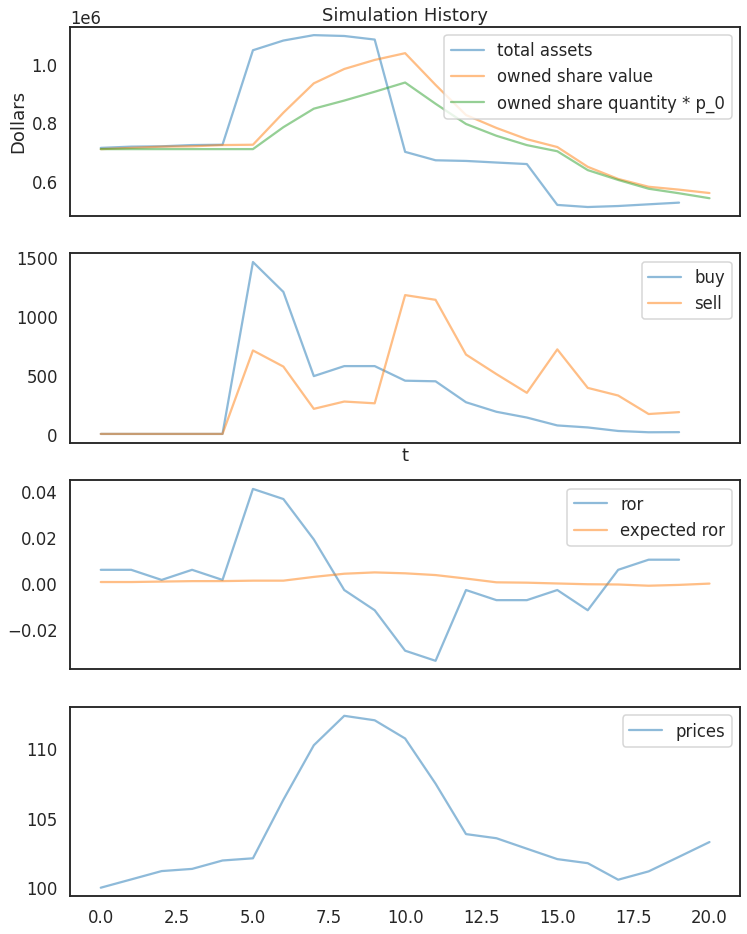

In [24]:
fig, ax = plt.subplots(
    4, 1,
    sharex='col',
    #sharey='col',
    figsize=(12,16),
)

ax[0].plot(total_asset_levels_list[1:], alpha=0.5, label='total assets')
ax[0].plot([p * o for (p,o) in zip(prices, owned_shares_list)], alpha=0.5, label='owned share value')
ax[0].plot([100 * o for (p,o) in zip(prices, owned_shares_list)], alpha=0.5, label='owned share quantity * p_0')
ax[0].legend()

ax[1].plot([bs[0] for bs in buy_sell_list], alpha=0.5, label='buy')
ax[1].plot([bs[1] for bs in buy_sell_list], alpha=0.5, label='sell')
ax[1].legend()

ax[2].plot(ror_list, alpha=0.5, label='ror')
ax[2].plot(expected_ror_list, alpha=0.5, label='expected ror')
ax[2].legend()

ax[3].plot(prices, alpha=0.5, label='prices')
ax[3].legend()
    
ax[0].set_title("Simulation History")
ax[0].set_ylabel("Dollars")
ax[1].set_xlabel("t")
        
plt.show()

In [25]:
data = pd.DataFrame.from_dict({
    't' : range(len(prices)),
    'prices' : prices,
    'buy' : [None] + [bs[0] for bs in buy_sell_list],
    'sell' : [None]  + [bs[1] for bs in buy_sell_list],
    'owned' : owned_shares_list,
    'total_assets' : total_asset_levels_list,
    'ror' : [None] + ror_list,
    'expected_ror' : expected_ror_list,
    #'expected_ror_q' : [ror_quarterly(er, days_per_quarter) for er in expected_ror_list],
    'expected_std' : expected_std_list,
    #'expected_std_q' : [sig_quarterly(es, days_per_quarter) for es in expected_std_list],
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,7097.978079,7.097978e+05,NaN,0.000628,0.011988
1,1,100.595429,0.0,0.0,7097.978079,7.140241e+05,0.005954,0.000628,0.011988
2,2,101.194403,0.0,0.0,7097.978079,7.182757e+05,0.005954,0.000829,0.011802
3,3,101.350944,0.0,0.0,7097.978079,7.193868e+05,0.001547,0.001022,0.011614
4,4,101.954416,0.0,0.0,7097.978079,7.236702e+05,0.005954,0.001035,0.011392
5,5,102.112133,0.0,0.0,7097.978079,7.247897e+05,0.001547,0.001224,0.011208
6,6,106.320491,1460.0,709.0,7849.001751,1.048460e+06,0.041213,0.001227,0.010993
7,7,110.233697,1206.0,572.0,8482.933841,1.081656e+06,0.036806,0.002863,0.013256
8,8,112.347577,491.0,213.0,8760.820116,1.100175e+06,0.019176,0.004248,0.014421
9,9,112.026215,576.0,275.0,9062.502280,1.097263e+06,-0.002860,0.004826,0.014280


In [26]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,-0.030858,-0.196378,0.327648,-0.434720,-0.476003,-0.252377,-0.338585,0.807483
prices,-0.030858,1.000000,0.693715,0.223965,0.808341,0.846204,0.180765,0.890480,0.073606
buy,-0.196378,0.693715,1.000000,0.461525,0.627619,0.755463,0.448645,0.533472,-0.153152
sell,0.327648,0.223965,0.461525,1.000000,0.287531,-0.016256,-0.369496,0.176455,0.474634
owned,-0.434720,0.808341,0.627619,0.287531,1.000000,0.858797,-0.075768,0.930106,-0.108087
total_assets,-0.476003,0.846204,0.755463,-0.016256,0.858797,1.000000,0.396138,0.836820,-0.324457
ror,-0.252377,0.180765,0.448645,-0.369496,-0.075768,0.396138,1.000000,-0.077258,-0.460302
expected_ror,-0.338585,0.890480,0.533472,0.176455,0.930106,0.836820,-0.077258,1.000000,-0.136657
expected_std,0.807483,0.073606,-0.153152,0.474634,-0.108087,-0.324457,-0.460302,-0.136657,1.000000


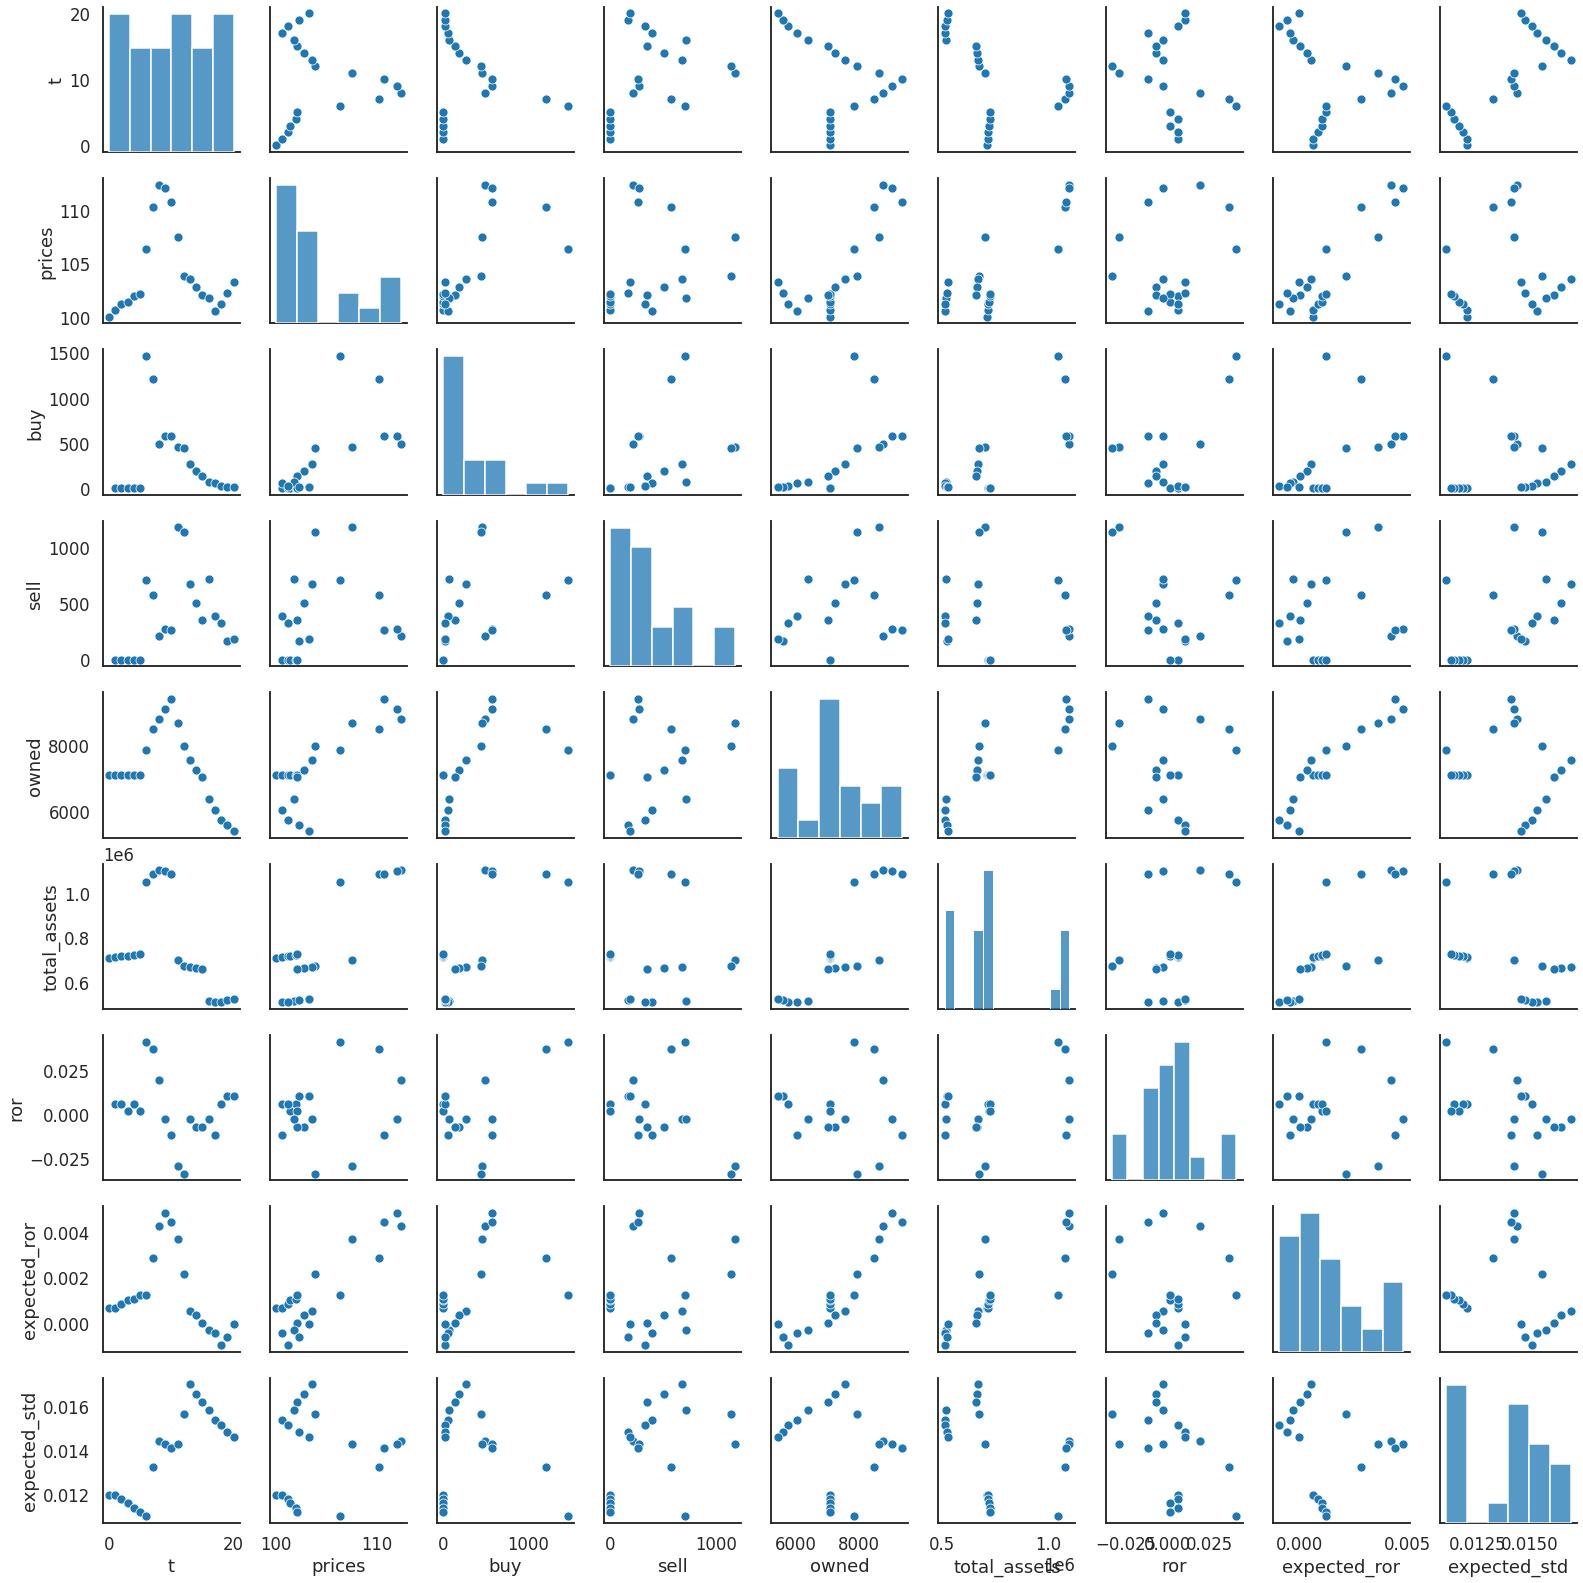

In [27]:
import seaborn as sns

sns.pairplot(data)

In [28]:
data['sell'].max()

1179.0

In [29]:
500 / 348


1.4367816091954022

<AxesSubplot:xlabel='t', ylabel='total_assets'>

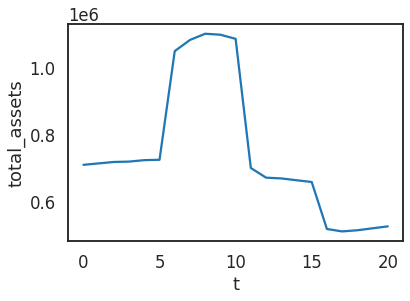

In [30]:
sns.lineplot(data= data, x = 't', y='total_assets')

<AxesSubplot:xlabel='t', ylabel='expected_ror'>

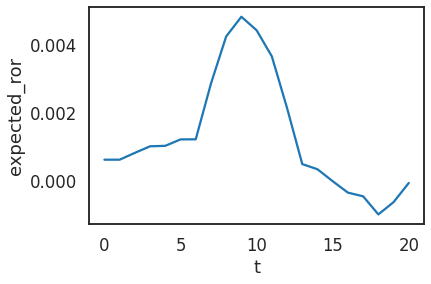

In [31]:
sns.lineplot(data= data, x = 't', y='expected_ror')

<AxesSubplot:xlabel='t', ylabel='expected_std'>

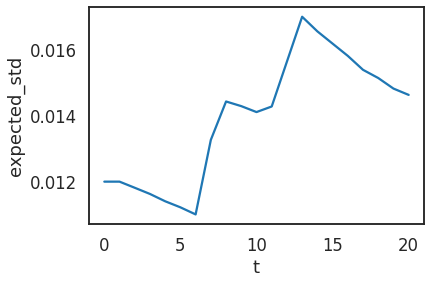

In [32]:
sns.lineplot(data= data, x = 't', y='expected_std')